# Analysis on California Data.
Can use this for other states.

In [1]:
%matplotlib inline

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import requests
import json
import copy
from typing import List
from urllib.request import urlretrieve
from urllib.parse import quote
import csv
import gmaps
import os
from config import g_key
# Access maps with unique API key
gmaps.configure(api_key=g_key)

# Import API key
from config import key
from config import email_key

Import saved csv. CSV includes data generated from 'StateCountySampleDataDF()' function.

In [3]:
# Import from .CSV
california_df = pd.read_csv("california_data.csv") 

In [4]:
california_df.head()

,state_code,state,county_code,county,site_number,parameter,sample_measurement,units_of_measure,latitude,longitude,date_local,time_local,date_gmt,time_gmt,method_type,method_code,method,date_of_last_change,cbsa_code
0,6,California,37,Los Angeles,1201,Acceptable PM2.5 AQI & Speciation Mass,5.8,Micrograms/cubic meter (LC),34.19925,-118.53276,2019-01-01,00:00,2019-01-01,08:00,Non-FRM,731,Met-One BAM-1020 W/PM2.5 SCC - Beta Attenuation,2019-06-24,31080
1,6,California,37,Los Angeles,1201,Acceptable PM2.5 AQI & Speciation Mass,4.6,Micrograms/cubic meter (LC),34.19925,-118.53276,2019-01-01,01:00,2019-01-01,09:00,Non-FRM,731,Met-One BAM-1020 W/PM2.5 SCC - Beta Attenuation,2019-06-24,31080
2,6,California,37,Los Angeles,1201,Acceptable PM2.5 AQI & Speciation Mass,2.8,Micrograms/cubic meter (LC),34.19925,-118.53276,2019-01-01,02:00,2019-01-01,10:00,Non-FRM,731,Met-One BAM-1020 W/PM2.5 SCC - Beta Attenuation,2019-06-24,31080
3,6,California,37,Los Angeles,1201,Acceptable PM2.5 AQI & Speciation Mass,4.8,Micrograms/cubic meter (LC),34.19925,-118.53276,2019-01-01,03:00,2019-01-01,11:00,Non-FRM,731,Met-One BAM-1020 W/PM2.5 SCC - Beta Attenuation,2019-06-24,31080
4,6,California,37,Los Angeles,1201,Acceptable PM2.5 AQI & Speciation Mass,3.0,Micrograms/cubic meter (LC),34.19925,-118.53276,2019-01-01,04:00,2019-01-01,12:00,Non-FRM,731,Met-One BAM-1020 W/PM2.5 SCC - Beta Attenuation,2019-06-24,31080


In [5]:
# Verify california is in dataframe
assert california_df['state'][0] == 'California'

In [6]:
# Make copy before filtering
california_filtered_df = california_df.copy()

## Clean Data before processing

Search for outliers in sample data.

In [8]:
# Find max value in sample data
california_filtered_df['sample_measurement'].max()

995.6

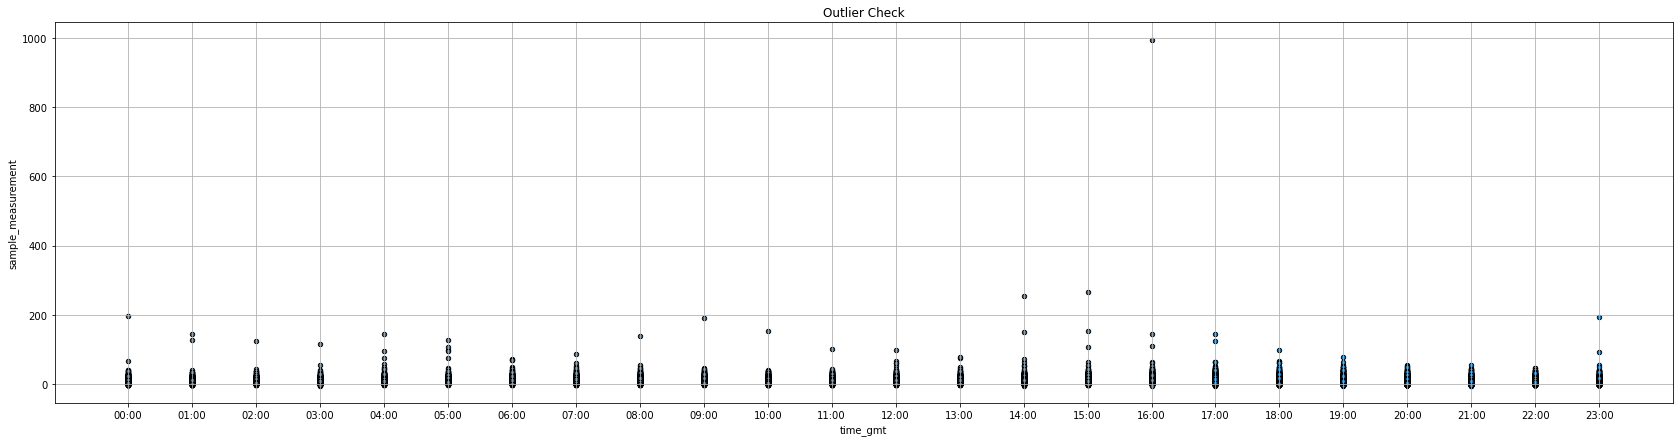

In [11]:
#Use Scatter Plot to visualize outliers.
california_filtered_df.sort_values(by='time_gmt', axis=0).plot('time_gmt', 
                    'sample_measurement', 
                    kind='scatter', 
                    grid=True, 
                    title=f'Outlier Check', 
                    edgecolors='black',
                    linewidths=.9,
                    figsize=(29, 7))

plt.show()

In [12]:
# Based off the scatter plot, outliers can be found with a sample data over 400. Show all outliers over 400 sample measurement.
outlier = california_filtered_df[(california_filtered_df[['sample_measurement']] > 400).all(axis=1)]
outlier

,state_code,state,county_code,county,site_number,parameter,sample_measurement,units_of_measure,latitude,longitude,date_local,time_local,date_gmt,time_gmt,method_type,method_code,method,date_of_last_change,cbsa_code
6800,6,California,37,Los Angeles,1201,Acceptable PM2.5 AQI & Speciation Mass,995.6,Micrograms/cubic meter (LC),34.19925,-118.53276,2019-10-11,08:00,2019-10-11,16:00,Non-FRM,731,Met-One BAM-1020 W/PM2.5 SCC - Beta Attenuation,2020-03-25,31080


### Cleaned dataframe being used for analysis

In [13]:
# Select certain columns to use for mapping, 
california_filtered_df=california_filtered_df[['county','site_number','sample_measurement','latitude','longitude','time_local','date_gmt','time_gmt','date_of_last_change']]
# Drop nan values and empty values
california_filtered_df=california_filtered_df.dropna()
# Remove all numbers below 0 and above 400
california_filtered_df=california_filtered_df[(california_filtered_df[['sample_measurement']] > 0).all(axis=1) & (california_filtered_df[['sample_measurement']] < 400).all(axis=1)]
# Assign date_gmt DateTimeIndex. Allows for date searching throug index.
california_filtered_df['date_gmt']=pd.DatetimeIndex(california_filtered_df['date_gmt'])
#Set index to date_gmt
california_filtered_df = california_filtered_df.set_index('date_gmt')

In [14]:
# Copy of clean data
california_clean_data = california_filtered_df.copy()

**Tool**: Search index by date range

In [15]:
# Search index by date range
california_clean_data['2019-01-01':'2019-02-02']

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-01-01,Los Angeles,1201,5.8,34.19925,-118.53276,00:00,08:00,2019-06-24
2019-01-01,Los Angeles,1201,4.6,34.19925,-118.53276,01:00,09:00,2019-06-24
2019-01-01,Los Angeles,1201,2.8,34.19925,-118.53276,02:00,10:00,2019-06-24
2019-01-01,Los Angeles,1201,4.8,34.19925,-118.53276,03:00,11:00,2019-06-24
2019-01-01,Los Angeles,1201,3.0,34.19925,-118.53276,04:00,12:00,2019-06-24
...,...,...,...,...,...,...,...,...
2019-02-02,Los Angeles,1103,6.0,34.06659,-118.22688,11:00,19:00,2019-06-27
2019-02-02,Los Angeles,1103,3.0,34.06659,-118.22688,12:00,20:00,2019-06-27
2019-02-02,Los Angeles,1103,2.0,34.06659,-118.22688,13:00,21:00,2019-06-27


In [16]:
# Unique values in index. Can use for graphs
#ca_dates = california_clean_data.sort_values(by='date_gmt', axis=0).index.unique()

## Single date - California Air Pollution Data
Date: 2019-01-01

In [17]:
# Single date - California Air Pollution Data
single_date_ca_air = california_clean_data.loc['2019-01-01']
single_date_ca_air
#california_clean_data

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-01-01,Los Angeles,1201,5.8,34.19925,-118.53276,00:00,08:00,2019-06-24
2019-01-01,Los Angeles,1201,4.6,34.19925,-118.53276,01:00,09:00,2019-06-24
2019-01-01,Los Angeles,1201,2.8,34.19925,-118.53276,02:00,10:00,2019-06-24
2019-01-01,Los Angeles,1201,4.8,34.19925,-118.53276,03:00,11:00,2019-06-24
2019-01-01,Los Angeles,1201,3.0,34.19925,-118.53276,04:00,12:00,2019-06-24
...,...,...,...,...,...,...,...,...
2019-01-01,Los Angeles,1103,12.0,34.06659,-118.22688,10:00,18:00,2019-06-27
2019-01-01,Los Angeles,1103,12.0,34.06659,-118.22688,11:00,19:00,2019-06-27
2019-01-01,Los Angeles,1103,7.0,34.06659,-118.22688,12:00,20:00,2019-06-27


In [26]:
range_time = single_date_ca_air['time_gmt'].sort_values().unique()
range_time

array(['08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00',
       '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00',
       '22:00', '23:00'], dtype=object)

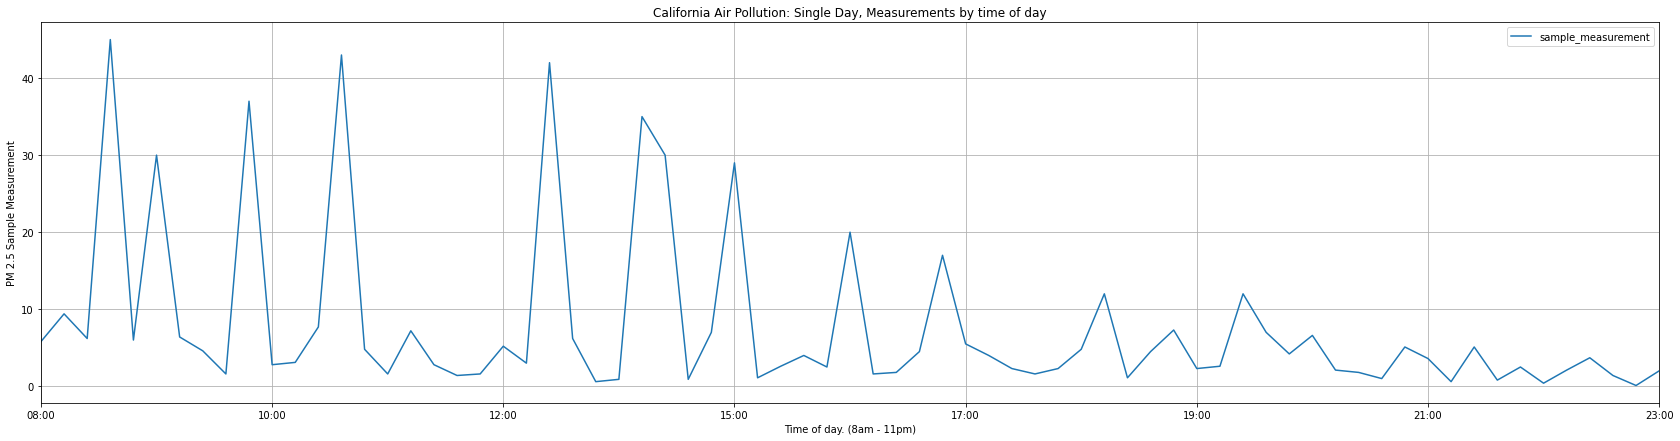

In [32]:
single_date_ca_air.sort_values(by='time_gmt', axis=0).plot(x='time_gmt', y='sample_measurement', kind='line', figsize=(29, 7),grid=True, title="California Air Pollution: Single Day, Measurements by time of day")
#plt.xticks(np.arange(int(test),int(test2), 3.5))
plt.ylabel('PM 2.5 Sample Measurement')
plt.xlabel('Time of day. (8am - 11pm)')
plt.xlim([0,70])
plt.show()

## Annual California Air Pollution. Measurements by time of day.
Date Range: 2019-01-01 - 2019-12-02

In [90]:
california_clean_data.sort_values(by='time_gmt', axis=0)

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-09-22,Los Angeles,16,15.2,34.14435,-117.85036,16:00,00:00,2020-02-06
2019-07-31,Los Angeles,1103,21.0,34.06659,-118.22688,16:00,00:00,2020-02-11
2019-10-15,Los Angeles,4004,9.3,33.79236,-118.17533,16:00,00:00,2020-03-31
2019-10-14,Los Angeles,4004,10.5,33.79236,-118.17533,16:00,00:00,2020-03-31
2019-08-09,Los Angeles,16,15.1,34.14435,-117.85036,16:00,00:00,2020-02-06
...,...,...,...,...,...,...,...,...
2019-01-23,Los Angeles,16,12.6,34.14435,-117.85036,15:00,23:00,2019-06-24
2019-02-04,Los Angeles,4004,4.8,33.79236,-118.17533,15:00,23:00,2019-06-24
2019-03-12,Los Angeles,6012,1.5,34.38344,-118.52840,15:00,23:00,2019-06-24


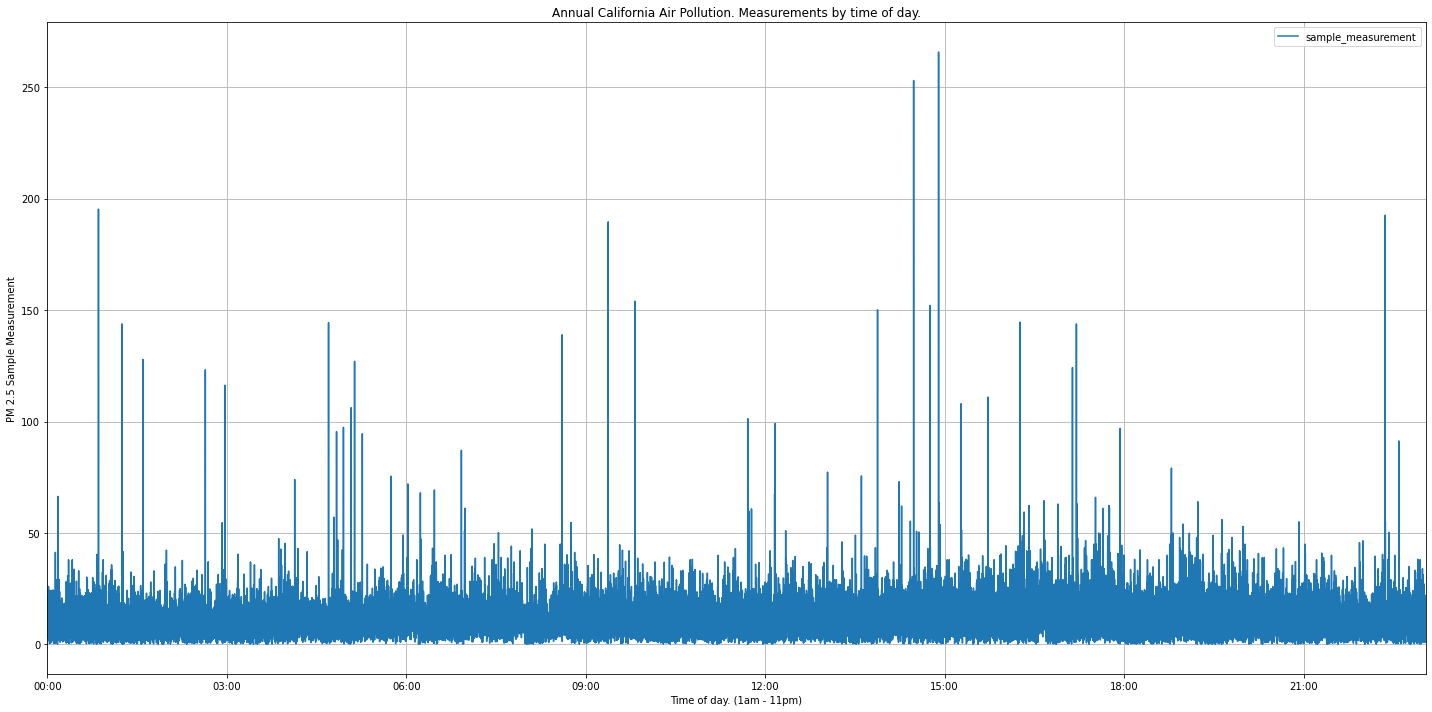

In [36]:
california_clean_data.sort_values(by='time_gmt', axis=0).plot(x='time_gmt', y='sample_measurement',figsize=(20, 10), grid=True, title='Annual California Air Pollution. Measurements by time of day.')
#plt.xticks(int(day_time_frame))
plt.ylabel('PM 2.5 Sample Measurement')
plt.xlabel('Time of day. (1am - 11pm)')
plt.xlim([0,38400])
plt.tight_layout()
plt.show()

## Monthly California Air Pollution. Measurements by time of day.
January

In [37]:
jan_data = california_clean_data['2019-01-01':'2019-01-31']
jan_data

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-01-01,Los Angeles,1201,5.8,34.19925,-118.53276,00:00,08:00,2019-06-24
2019-01-01,Los Angeles,1201,4.6,34.19925,-118.53276,01:00,09:00,2019-06-24
2019-01-01,Los Angeles,1201,2.8,34.19925,-118.53276,02:00,10:00,2019-06-24
2019-01-01,Los Angeles,1201,4.8,34.19925,-118.53276,03:00,11:00,2019-06-24
2019-01-01,Los Angeles,1201,3.0,34.19925,-118.53276,04:00,12:00,2019-06-24
...,...,...,...,...,...,...,...,...
2019-01-31,Los Angeles,1103,21.0,34.06659,-118.22688,11:00,19:00,2019-06-27
2019-01-31,Los Angeles,1103,10.0,34.06659,-118.22688,12:00,20:00,2019-06-27
2019-01-31,Los Angeles,1103,20.0,34.06659,-118.22688,13:00,21:00,2019-06-27


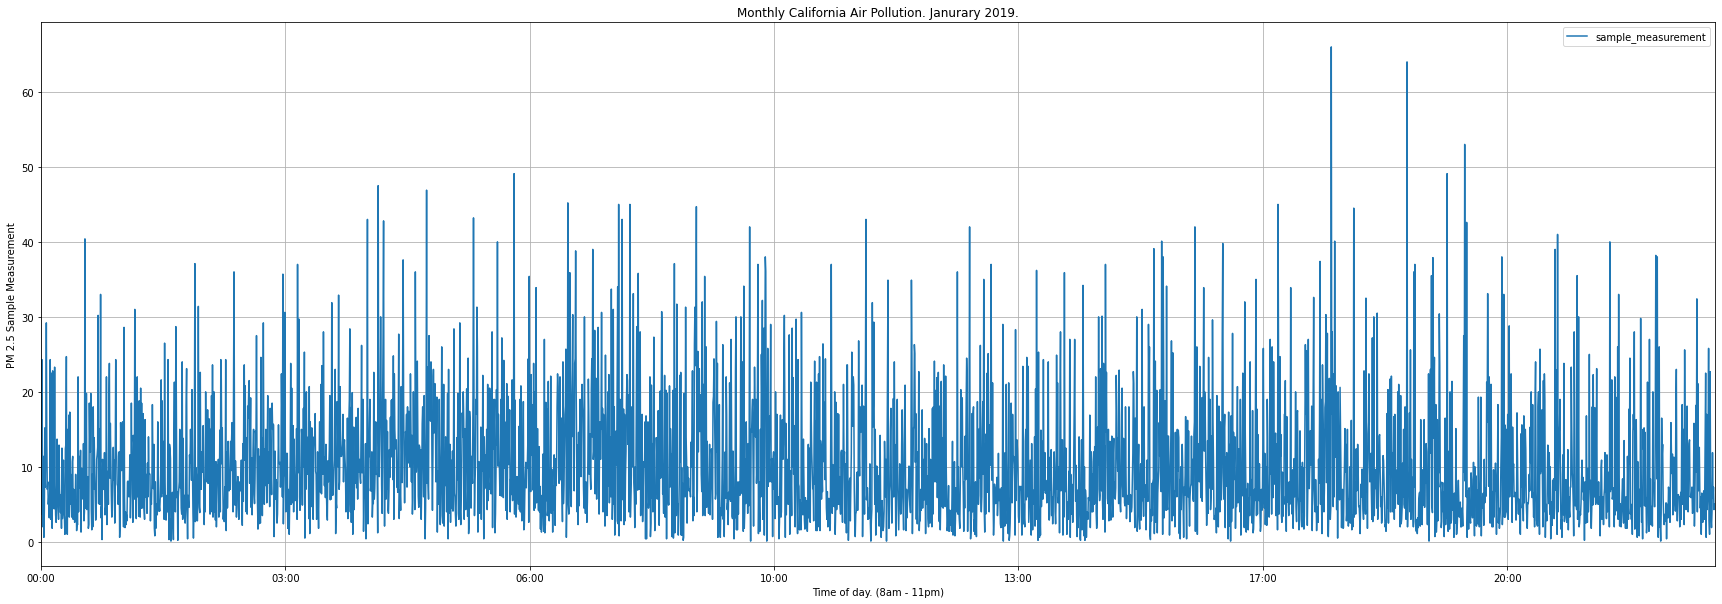

In [45]:
jan = jan_data.sort_values(by='time_gmt', axis=0).plot(x='time_gmt', y='sample_measurement',figsize=(30, 10),grid=True, title='Monthly California Air Pollution. Janurary 2019.')
#plt.xticks()
plt.ylabel('PM 2.5 Sample Measurement')
plt.xlabel('Time of day. (8am - 11pm)')
plt.xlim([0,3425])
plt.show()

Feburary

In [46]:
feb_data = california_clean_data['2019-02-01':'2019-02']
feb_data

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-02-01,Los Angeles,1201,3.6,34.19925,-118.53276,16:00,00:00,2019-06-24
2019-02-01,Los Angeles,1201,2.8,34.19925,-118.53276,17:00,01:00,2019-06-24
2019-02-01,Los Angeles,1201,7.3,34.19925,-118.53276,18:00,02:00,2019-06-24
2019-02-01,Los Angeles,1201,8.8,34.19925,-118.53276,19:00,03:00,2019-06-24
2019-02-01,Los Angeles,1201,9.7,34.19925,-118.53276,20:00,04:00,2019-06-24
...,...,...,...,...,...,...,...,...
2019-02-28,Los Angeles,1103,16.0,34.06659,-118.22688,11:00,19:00,2019-06-27
2019-02-28,Los Angeles,1103,14.0,34.06659,-118.22688,12:00,20:00,2019-06-27
2019-02-28,Los Angeles,1103,9.0,34.06659,-118.22688,13:00,21:00,2019-06-27


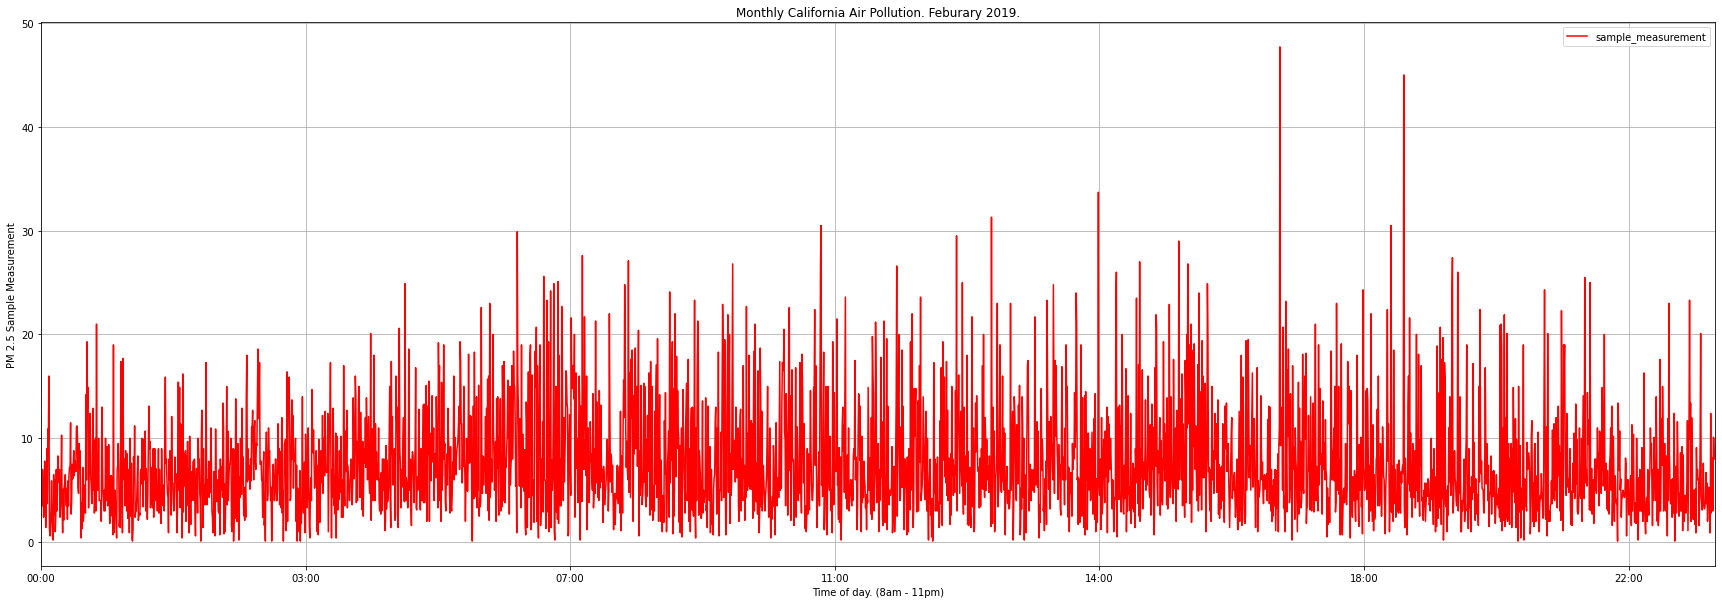

In [47]:
feb = feb_data.sort_values(by='time_gmt', axis=0).plot(x='time_gmt', y='sample_measurement',figsize=(30, 10),c='r',grid=True, title='Monthly California Air Pollution. Feburary 2019.')
#plt.xticks(np.arange(int(test),int(test2), 3.5))
plt.ylabel('PM 2.5 Sample Measurement')
plt.xlabel('Time of day. (8am - 11pm)')
plt.xlim([0,3163])
plt.show()

ROUGH NOTES BELOW. Not Cleaned.

In [56]:
jan_data.mean()

site_number           2290.520584
sample_measurement      10.364058
latitude                34.102604
longitude             -118.247642
dtype: float64

TypeError: cannot unpack non-iterable AxesSubplot object

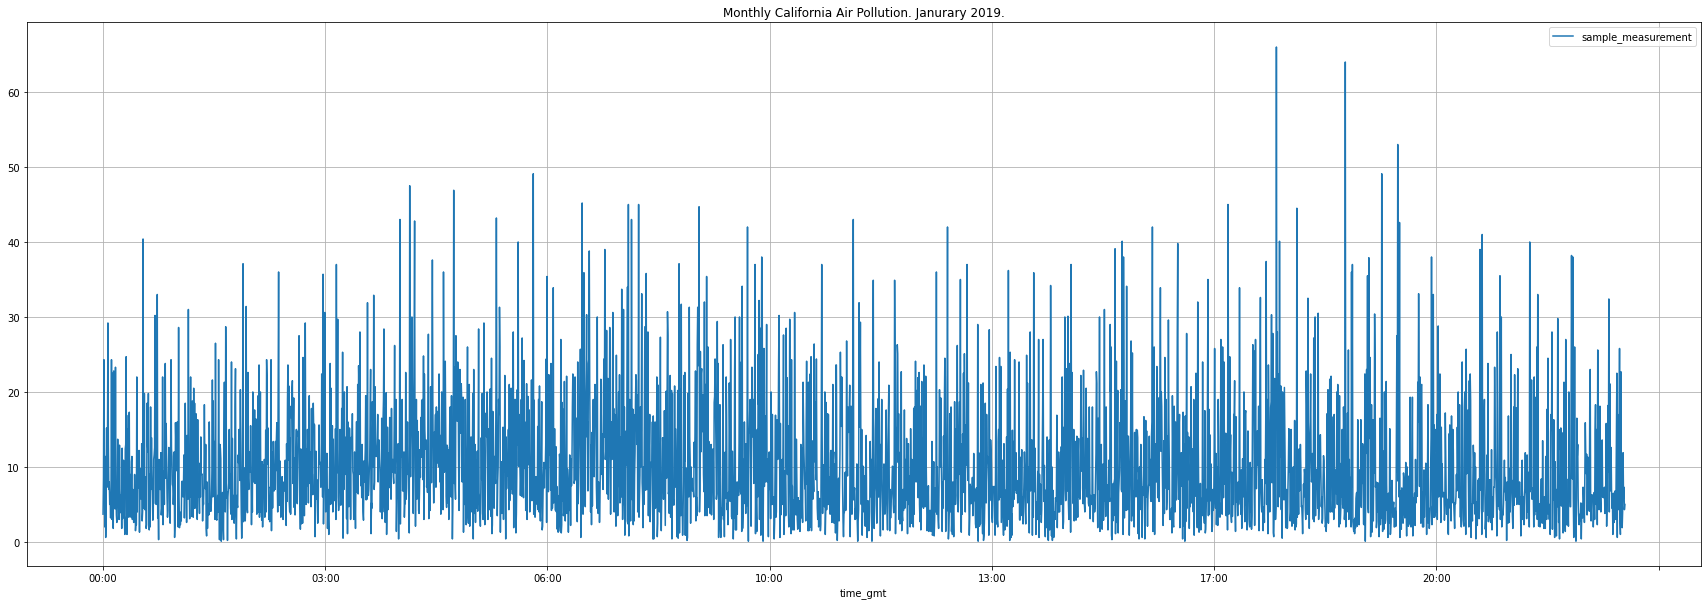

In [54]:
jan, = jan_data.sort_values(by='time_gmt', axis=0).plot(x='time_gmt', y='sample_measurement',figsize=(30, 10),grid=True, title='Monthly California Air Pollution. Janurary 2019.')
feb, = feb_data.sort_values(by='time_gmt', axis=0).plot(x='time_gmt', y='sample_measurement',figsize=(30, 10),c='r',grid=True, title='Monthly California Air Pollution. Feburary 2019.')

plt.legend(handles=[jan, feb], loc='best')
plt.show()